In [1]:
# Import necessary modules
import numpy as np
import os
import pandas as pd
import sys

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.ga.ga_member import Member
from core.ga.ga_params import GeneticAlgorithmParams

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.plotting.plotting import *

## Control Inputs

In [2]:
'''
# Carla test params
irrigation_frequency = 24 * 7 * 2 # Irrigate once every 336 hours
irrigation_amount    = 0.01        # with 0.01 inches per irrigation (goal is 28 in including precip)
fertilizer_frequency = 24 * 30 * 3 # Fertilize once every 2160 hours
fertilizer_amount    = 175        # with 175 lbs per fertilization (goal is 355 lbs over season)

# Example bad params
irrigation_frequency = 1
irrigation_amount    = 0
fertilizer_frequency = 1
fertilizer_amount    = 0
'''
# Example good params
irrigation_frequency = 2180.6889931261135
irrigation_amount    = 0.16052169009727058
fertilizer_frequency = 1460.976514193387
fertilizer_amount    = 125.38554553302795

## Model Parameters

In [3]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt               = 0.1,  # hours/step
    simulation_hours = 2900, # hours
    closed_form      = True,
    verbose          = True
)

In [4]:
# Set ModelCarryingCapacities
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [5]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [6]:
# Set ModelSensitivities
sensitivities = ModelSensitivities(
    sigma_W = 30,  # hrs
    sigma_F = 300, # hrs
    sigma_T = 30,  # hrs
    sigma_R = 30   # hrs
)

In [7]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)

## Cost function weights

In [8]:
ga_params = GeneticAlgorithmParams()
weight_fruit_biomass = ga_params.weight_fruit_biomass
weight_irrigation    = ga_params.weight_irrigation
weight_fertilizer    = ga_params.weight_fertilizer

## Input Disturbances

In [9]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../../io/inputs/hourly_prcp_rad_temp_iowa.csv'
)

In [10]:
# Set ModelDisturbances
input_disturbances = ModelDisturbances(
    precipitation = hourly_input_disturbances['Hourly Precipitation (in)'].to_numpy(), # let's say it's a drought year
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

## Get hourly control inputs from irrigation/fertilizer amount/frequency

In [11]:
# Apply irrigation and fertilizer based on the defined frequency and amount
simulation_hours = len(input_disturbances.precipitation)
hourly_irrigation = np.zeros(simulation_hours)
for t in range(0, simulation_hours, np.floor(irrigation_frequency).astype(int)):
    hourly_irrigation[t] = irrigation_amount

hourly_fertilizer = np.zeros(simulation_hours)
for t in range(0, simulation_hours, np.floor(fertilizer_frequency).astype(int)):
    hourly_fertilizer[t] = fertilizer_amount

## Plot inputs and disturbances

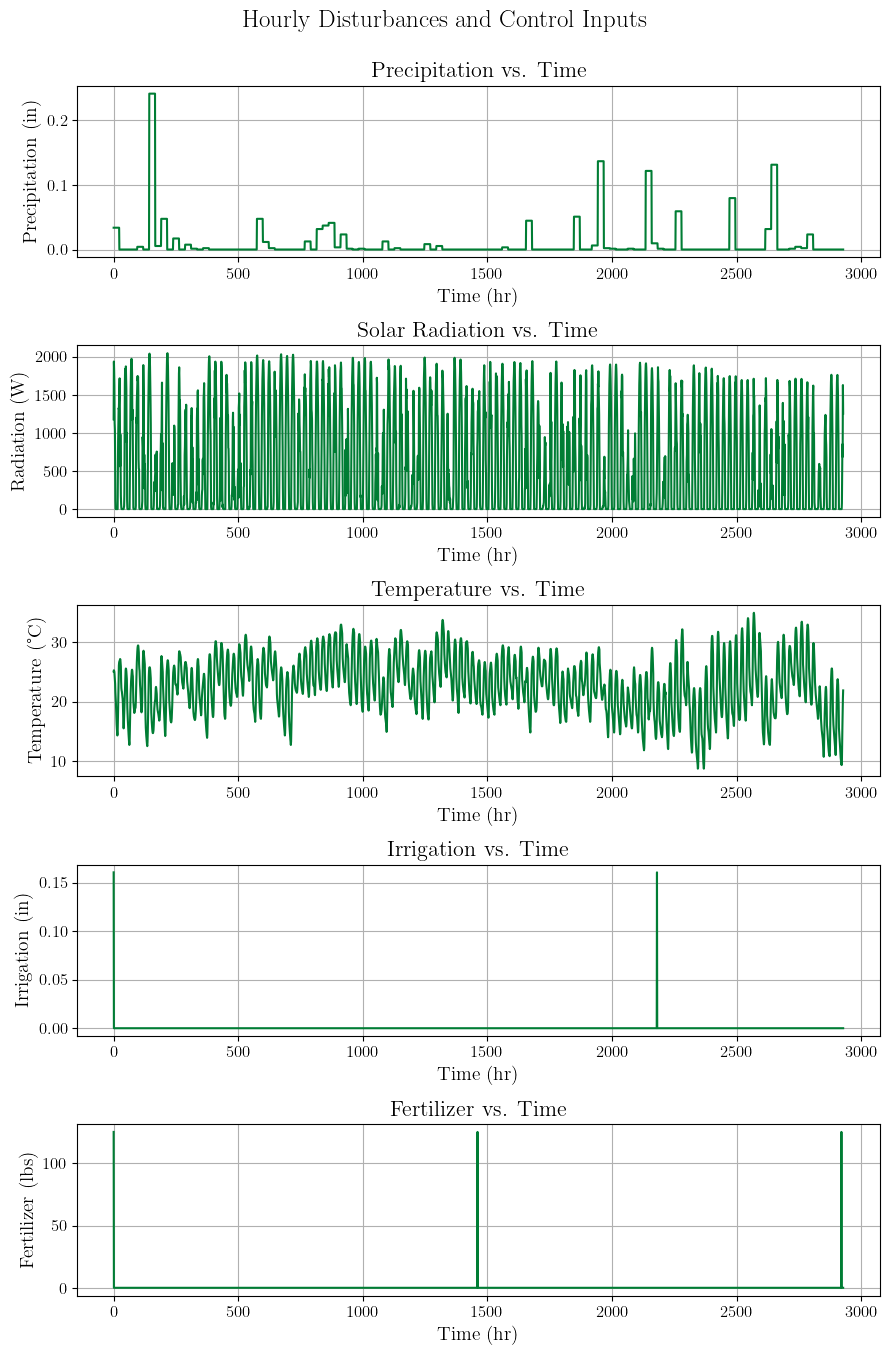

In [12]:
plot_hourly_inputs(
    input_disturbances,
    hourly_irrigation,
    hourly_fertilizer
)

In [13]:
# Convert inputs from hourly to simulation time steps
from core.model.model_helpers import get_sim_inputs_from_hourly

hourly_irrigation = np.zeros(simulation_hours)
step_if = max(1, int(np.ceil(irrigation_frequency)))
hourly_irrigation[::step_if] = irrigation_amount
irrigation = get_sim_inputs_from_hourly(hourly_irrigation, model_params.dt, simulation_hours, mode='split')

hourly_fertilizer = np.zeros(simulation_hours)
step_ff = max(1, int(np.ceil(fertilizer_frequency)))
hourly_fertilizer[::step_ff] = fertilizer_amount
fertilizer = get_sim_inputs_from_hourly(hourly_fertilizer, model_params.dt, simulation_hours, mode='split')

temperature   = get_sim_inputs_from_hourly(input_disturbances.temperature,   model_params.dt, simulation_hours, mode='split')
radiation     = get_sim_inputs_from_hourly(input_disturbances.radiation,     model_params.dt, simulation_hours, mode='split')
precipitation = get_sim_inputs_from_hourly(input_disturbances.precipitation, model_params.dt, simulation_hours, mode='split')

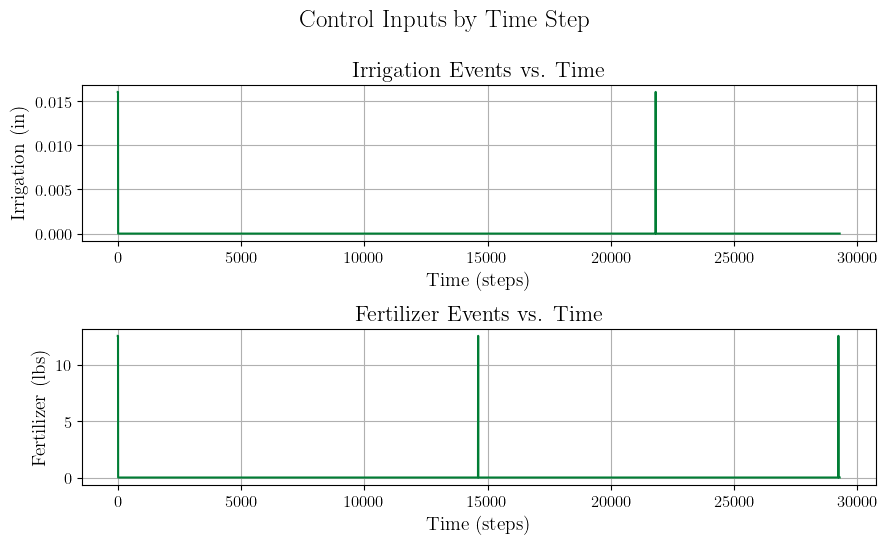

In [14]:
plot_control_inputs(
    irrigation,
    fertilizer
)

## Optimal/Typical Values

In [15]:
default_typical_disturbances = ModelTypicalDisturbances()

typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)

## GA Params (just to use Member class)

In [16]:
# Genetic algorithm style inputs
ga_params = GeneticAlgorithmParams()

## Simulation of Plant Growth over Season

In [17]:
# Construct an instance of the Member class and get the cost
member = Member(
    ga_params            = ga_params,
    carrying_capacities  = carrying_capacities,
    disturbances         = input_disturbances,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    model_params         = model_params,
    typical_disturbances = typical_disturbances,
    sensitivities        = sensitivities,
    values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
)
member.get_cost()

-732.0151878931105

In [18]:
# Read results from the output csv file
output = pd.read_csv('output_get_cost.csv')

h = output['h'].to_numpy()
A = output['A'].to_numpy()
N = output['N'].to_numpy()
c = output['c'].to_numpy()
P = output['P'].to_numpy()

delayed_water       = output['delayed_water'].to_numpy()
delayed_fertilizer  = output['delayed_fertilizer'].to_numpy()
delayed_temperature = output['delayed_temperature'].to_numpy()
delayed_radiation   = output['delayed_radiation'].to_numpy()

cumulative_water       = output['cumulative_water'].to_numpy()
cumulative_fertilizer  = output['cumulative_fertilizer'].to_numpy()
cumulative_temperature = output['cumulative_temperature'].to_numpy()
cumulative_radiation   = output['cumulative_radiation'].to_numpy()

delta_cumulative_water       = output['delta_cumulative_water'].to_numpy()
delta_cumulative_fertilizer  = output['delta_cumulative_fertilizer'].to_numpy()
delta_cumulative_temperature = output['delta_cumulative_temperature'].to_numpy()
delta_cumulative_radiation   = output['delta_cumulative_radiation'].to_numpy()

nuWs = output['nuW'].to_numpy()
nuFs = output['nuF'].to_numpy()
nuTs = output['nuT'].to_numpy()
nuRs = output['nuR'].to_numpy()

ah_hat = output['ah_hat'].to_numpy()
aA_hat = output['aA_hat'].to_numpy()
aN_hat = output['aN_hat'].to_numpy()
ac_hat = output['ac_hat'].to_numpy()
aP_hat = output['aP_hat'].to_numpy()

kh_hat = output['kh_hat'].to_numpy()
kA_hat = output['kA_hat'].to_numpy()
kN_hat = output['kN_hat'].to_numpy()
kc_hat = output['kc_hat'].to_numpy()
kP_hat = output['kP_hat'].to_numpy()

## Plot crop growth results

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:186: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:194: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:202: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

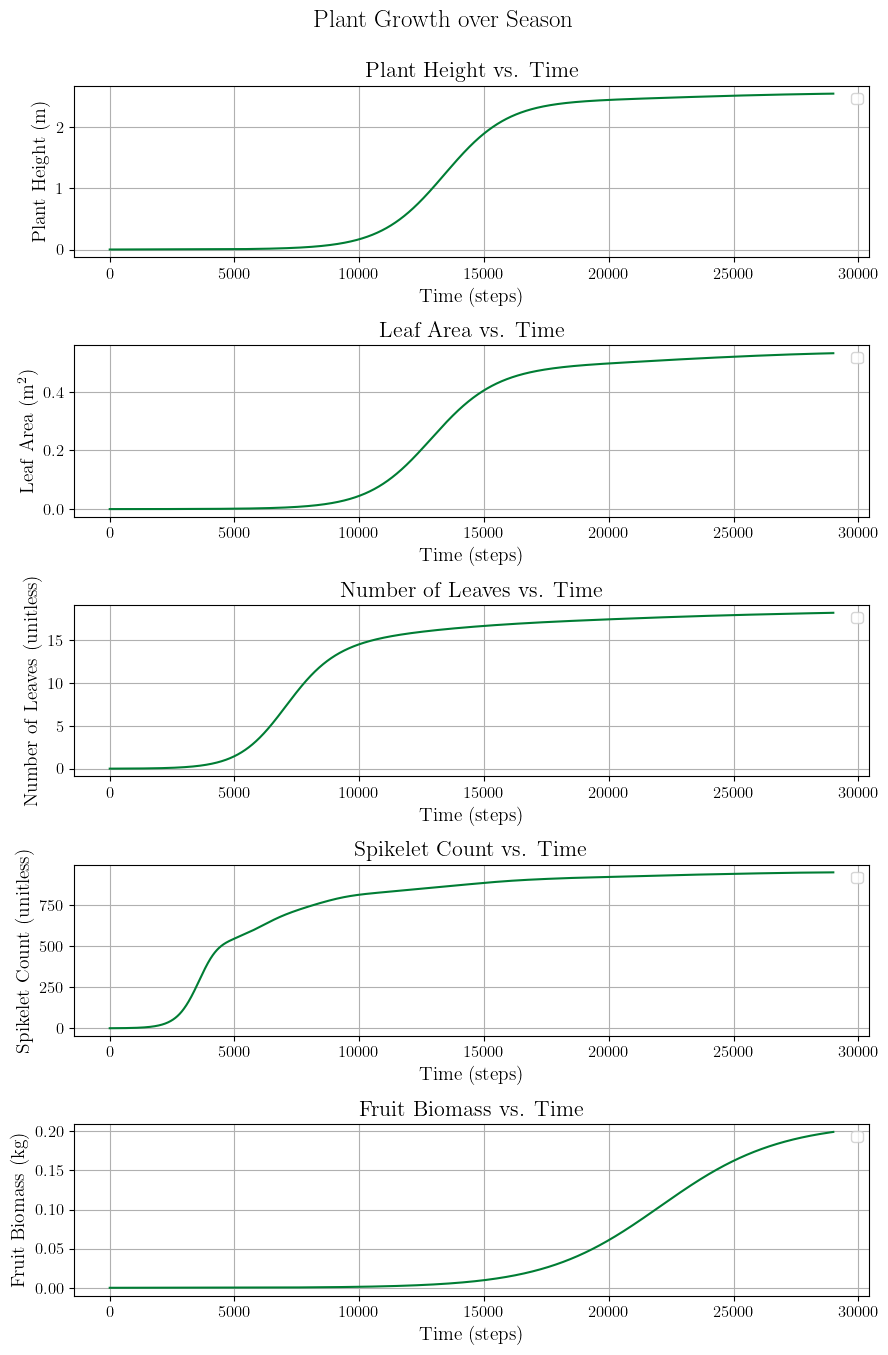

In [19]:
plot_crop_growth_results(
    hs = [h],
    As = [A],
    Ns = [N],
    cs = [c],
    Ps = [P]
)

In [20]:
profit = weight_fruit_biomass * P[-1]
expenses = (weight_irrigation * np.sum(hourly_irrigation)
            + weight_fertilizer * np.sum(hourly_fertilizer))
revenue = profit - expenses

print(f'weight_fruit_biomass: {weight_fruit_biomass}')
print(f'weight_irrigation: {weight_irrigation}')
print(f'weight_fertilizer: {weight_fertilizer}')
print(f'Fruit biomass: {P[-1]}')

print(f'\n')

print(f'Profit: ${profit:.2f}')
print(f'Irrigation used (in): {np.sum(hourly_irrigation):.2f}, irrigation expense: ${weight_irrigation * np.sum(hourly_irrigation):.2f}')
print(f'Fertilizer used (lbs): {np.sum(hourly_fertilizer):.2f}, fertilizer expense: ${weight_fertilizer * np.sum(hourly_fertilizer):.2f}')
print(f'Expenses: ${expenses:.2f}')
print(f'Revenue: ${revenue:.2f}')

weight_fruit_biomass: 4450
weight_irrigation: 2.0
weight_fertilizer: 0.614
Fruit biomass: 0.1992428594534961


Profit: $886.63
Irrigation used (in): 0.32, irrigation expense: $0.64
Fertilizer used (lbs): 376.16, fertilizer expense: $230.96
Expenses: $231.60
Revenue: $655.03


## Plot input and disturbance evolution with delays taken into account

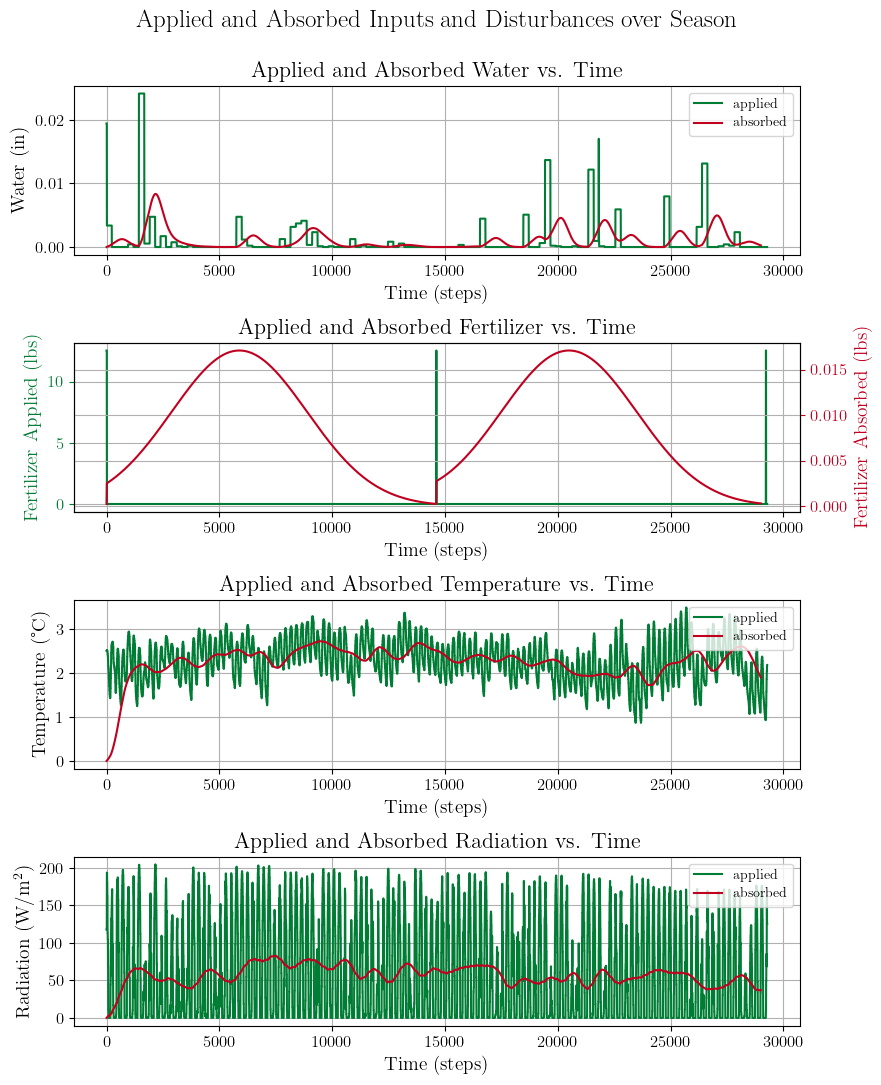

In [21]:
plot_applied_vs_absorbed(
        irrigation,
        precipitation,
        delayed_water,
        fertilizer,
        delayed_fertilizer,
        temperature,
        delayed_temperature,
        radiation,
        delayed_radiation
)

## Plot cumulative value evolution

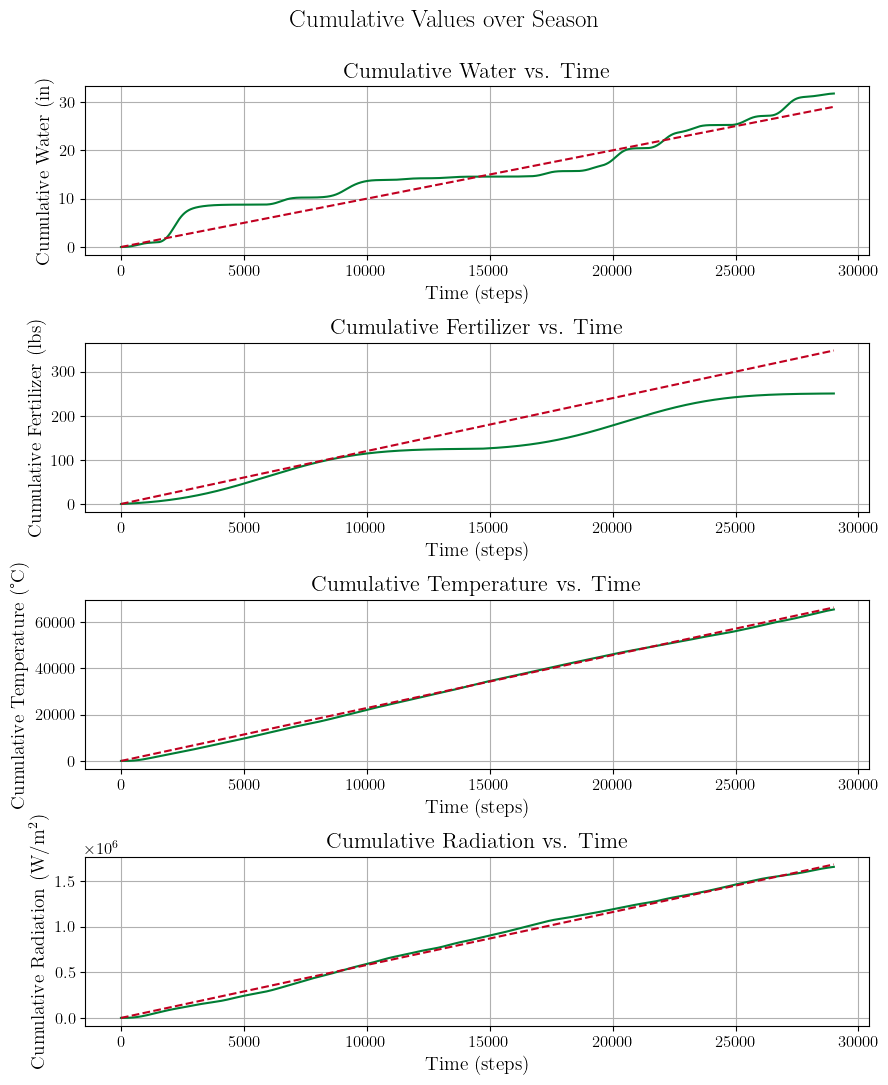

In [22]:
plot_cumulative_values(
    cumulative_water,
    cumulative_fertilizer,
    cumulative_temperature,
    cumulative_radiation,
    typical_disturbances
)

## Plot the deltas between actual and expected cumulative value

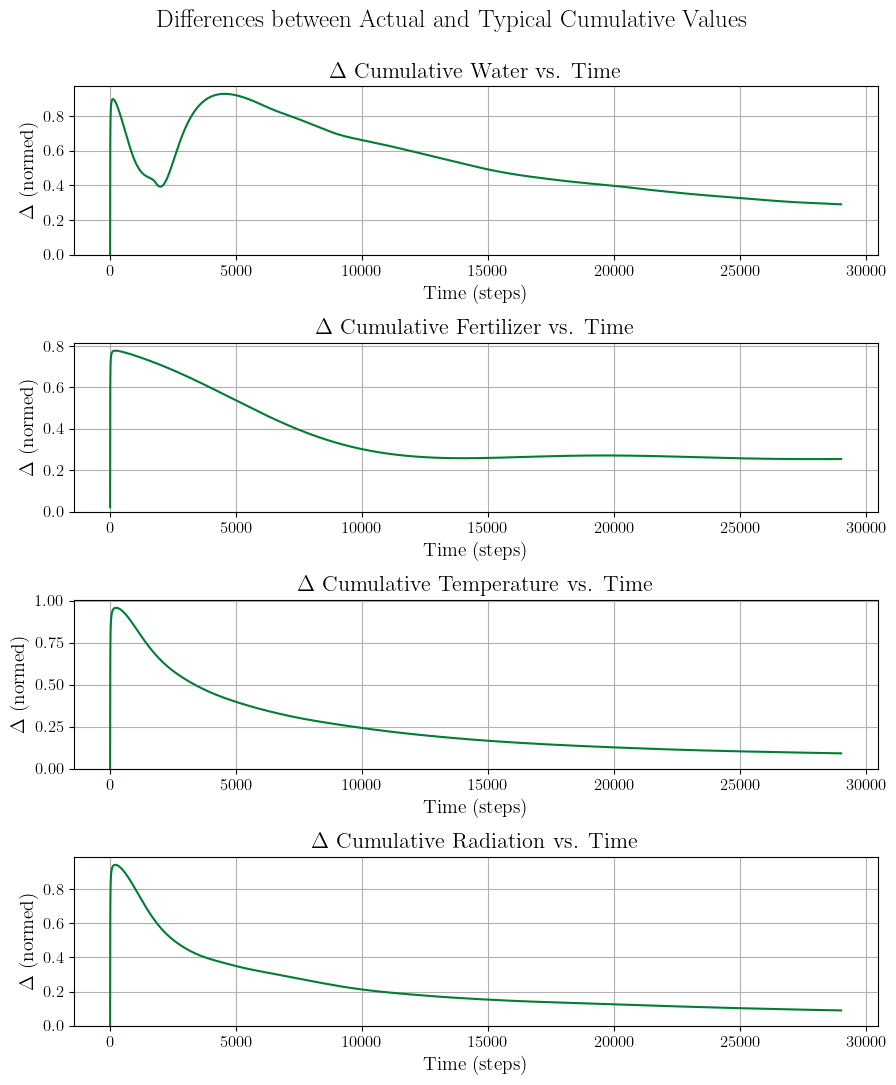

In [23]:
plot_actual_vs_expected_cumulatives(
    delta_cumulative_water,
    delta_cumulative_fertilizer,
    delta_cumulative_temperature,
    delta_cumulative_radiation
)

## Plot nutrient factor evolution

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:502: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:512: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:522: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

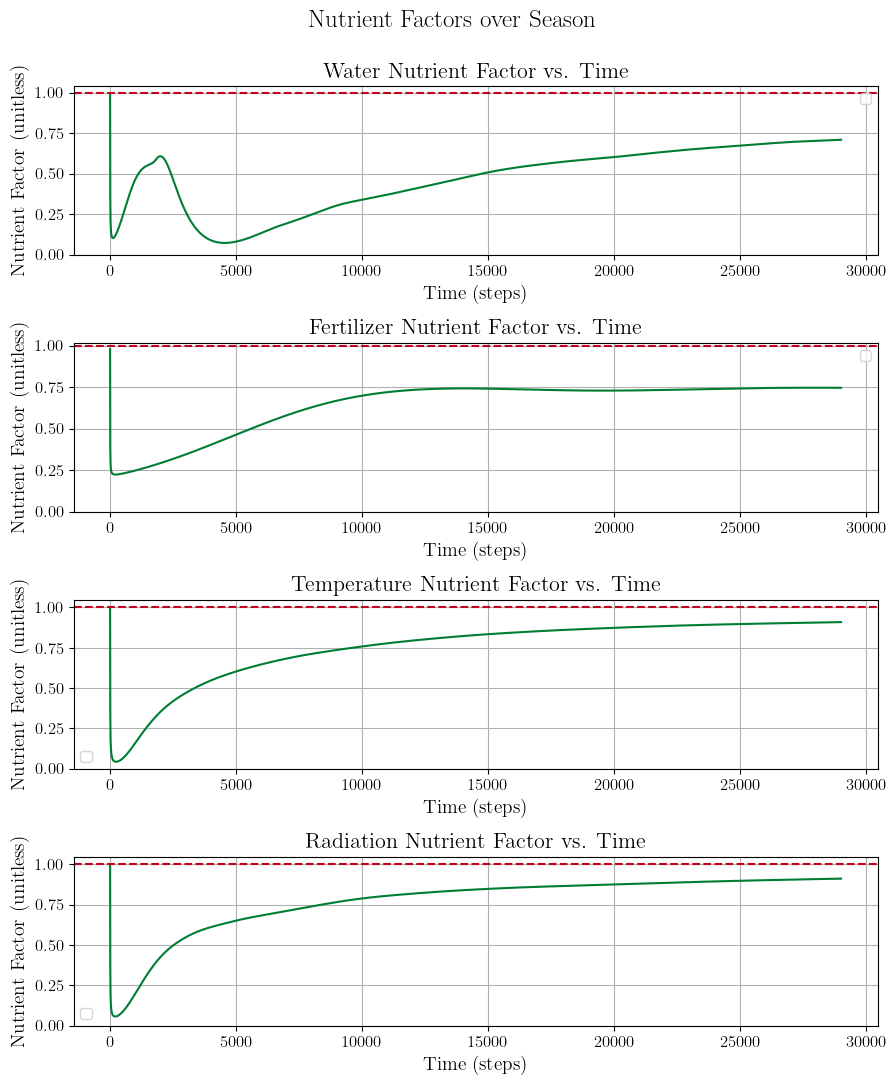

In [24]:
plot_nutrient_factor_evolution(
    [nuWs],
    [nuFs],
    [nuTs],
    [nuRs]
)

## Plot growth rates over time

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:591: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:601: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:611: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

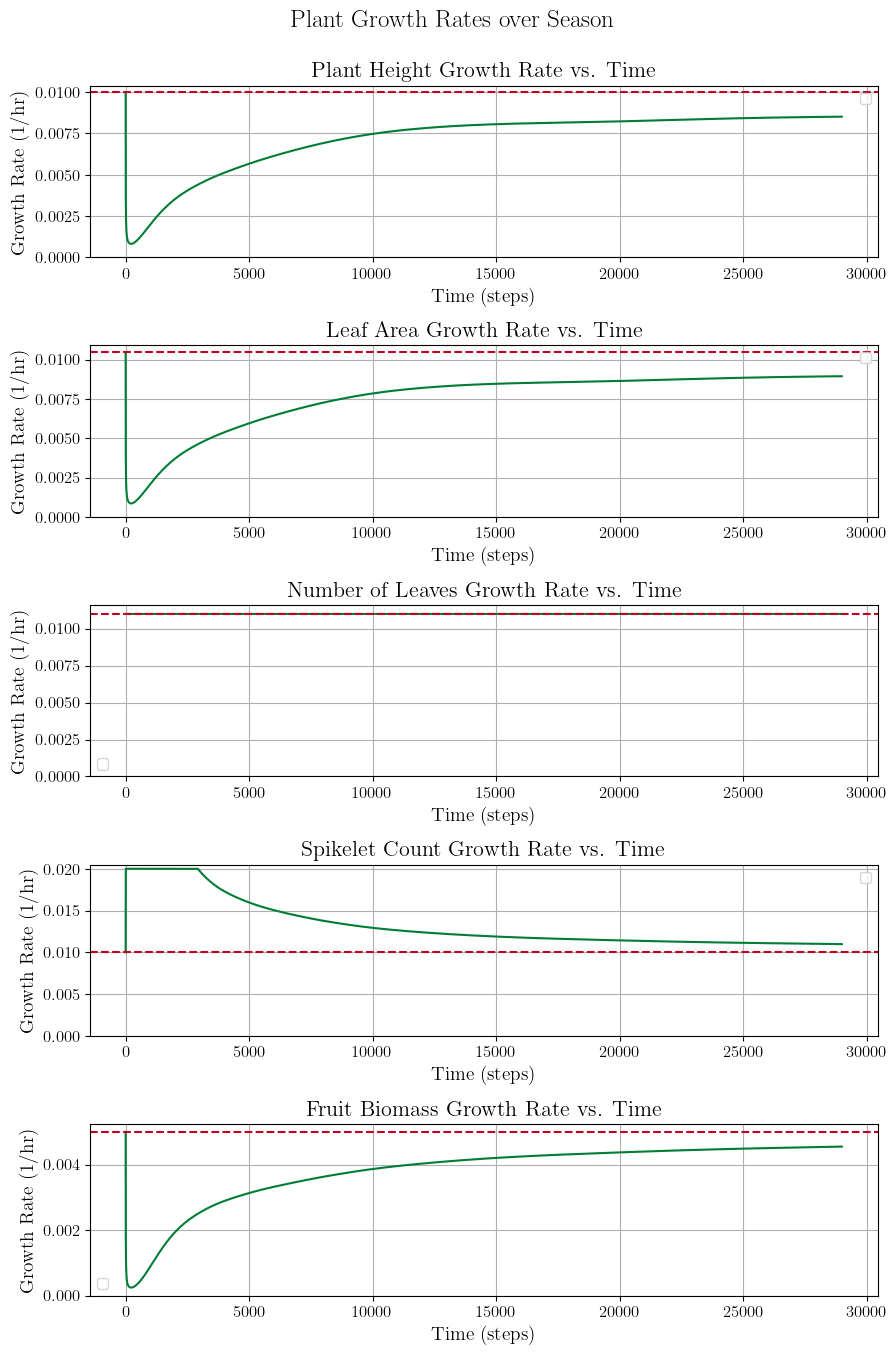

In [25]:
plot_growth_rate_evolution(
        growth_rates,
        [ah_hat],
        [aA_hat],
        [aN_hat],
        [ac_hat],
        [aP_hat],
)

## Plot carrying capacities over time

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:693: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:703: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:713: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

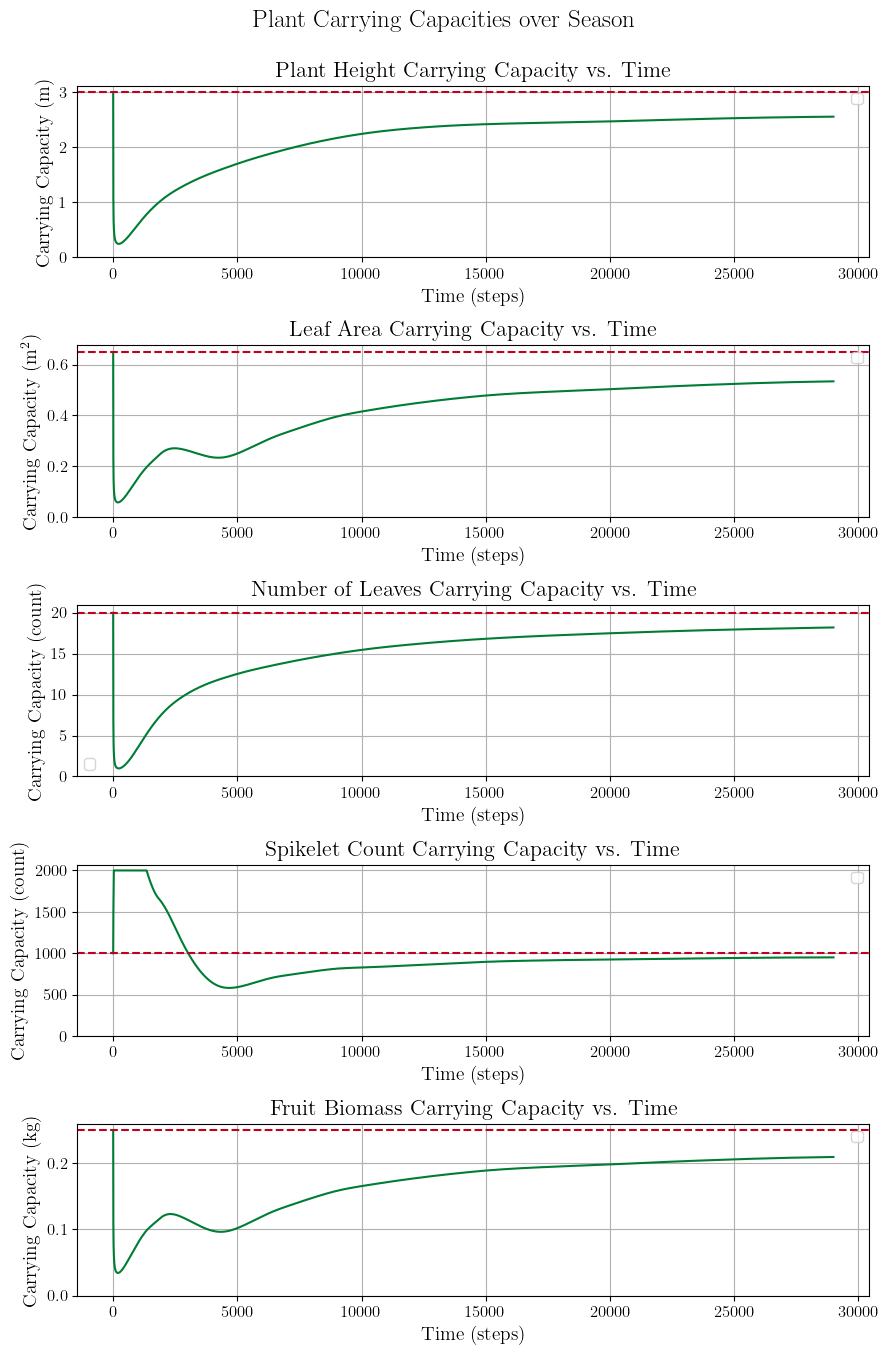

In [26]:
plot_carrying_capacity_evolution(
        carrying_capacities,
        [kh_hat],
        [kA_hat],
        [kN_hat],
        [kc_hat],
        [kP_hat]
)